In [1]:
import math
import numpy as np
import itertools as it
from sys import stderr
from numpy.linalg import inv
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

from mpcsimplified import *
from databinning import *


In [2]:
class ControllerFPD:
    """Class implementing the control from demonstartion algorithm"""

    def __init__(self, f_x, g_x, sys) -> None:
        """Initialize probabilistic descriptions of the system to be controlled and of the target system and the instance of the deterministic model.

        Args:
            f_x (numpy.ndarray[float64]): Probabilistic description of the system to be controlled.
            g_x (numpy.ndarray[float64]): Probabilistic description of the target system.
            sys (ToggleSwitchSimplified): Instance of the deterministic model.
        """

        self.f_x = f_x
        self.g_x = g_x
        self.sys = sys

    def dkl(f_x, g_x):
        """Compute analytically the Kullback-Leibler divergence.

        Args:
            f_x (numpy.ndarray[float64]): Probabilistic description of the system to be controlled.
            g_x (numpy.ndarray[float64]): Probabilistic description of the target system.

        Returns:
            float64: Value of the Kullback-Leibler divergence.
        """

        arr = np.zeros(f_x.shape[0] * f_x.shape[1])

        for i in range(f_x.shape[0]):
            for j in range(f_x.shape[1]):
                if f_x[(i, j)] != 0 and g_x[(i, j)] != 0:
                    arr[(i*f_x.shape[1]) + j] = f_x[(i, j)] * \
                        math.log(f_x[(i, j)]/g_x[(i, j)])

        return np.sum(arr)

    def gaussianDKL(self, mu1, mu2, cov1, cov2, dim):
        """Compute numerically the Kullback-Leibler divergence.

        Args:
            mu1 (float64): Mean of the next state of the system to be controlled.
            mu2 (float64): Mean of the next state of the target system.
            cov1 (numpy.ndarray[float64]): Covariance of the next state of the system to be controlled.
            cov2 (numpy.ndarray[float64]): Covariance of the next state of the target system.
            dim (int): Number of states.

        Returns:
            float64: Value of the Kullback-Leibler divergence.
        """

        el1 = np.trace(np.dot(inv(cov2), cov1))
        el2 = np.dot(np.dot(np.transpose(np.subtract(mu2, mu1)), inv(cov2)), (np.subtract(mu2, mu1)))
        el3 = np.log(((np.linalg.det(cov2))/(np.linalg.det(cov1)))) if np.linalg.det(cov1) != 0 else 0

        return 0.5*(el1 + el2 - dim + el3)

    def discretize(self, elm, dim, min, step, max):
        """Returns the discrete index associated with a continuous state or input value.

        Args:
            elm (numpy.ndarray[float64]): Array containing the continuous values of the states/inputs.
            dim (int): Number of states/inputs.
            min (numpy.ndarray[float64]): Array containing the minimum values of the states/inputs.
            step (numpy.ndarray[float64]): Array containing the discretization step of the states/inputs.
            max (numpy.ndarray[float64]): Array containing the maximum values of the states/inputs.

        Returns:
            tuple: Tuple of indices associated with states/inputs.
        """

        indices = [0]*dim
        for i in range(dim):
            value = max[i] - step[i] if elm[i] >= max[i] else elm[i]
            indices[i] = int((value - min[i])//step[i])

        return(tuple(indices))

    def makeFPDStep(self, uk, u_step, u_discr, u_axis, x_dim, x_min, x_step, x_max):
        """It calculates the optimal policy and samples the control input to be applied to the system.

        Args:
            uk (numpy.ndarray[float64]): Current target input
            u_step (numpy.ndarray[float64]): Array containing the discretization step of the inputs.
            u_discr (numpy.ndarray[float64]): Array containing the number of bins for each input.
            u_axis (numpy.ndarray[float64]): X-axis of possible state values. 
            x_dim (int): Number of states.
            x_min (numpy.ndarray[float64]): Array containing the minimum values of the states.
            x_step (numpy.ndarray[float64]): Array containing the discretization step of the states.
            x_max (numpy.ndarray[float64]): Array containing the maximum values of the states.

        Returns:
            numpy.ndarray[float64]: Input sampled by the optimal policy.
        """

        g_pf = multivariate_normal(uk, np.array([[u_step[0], 0], [0, 0.1*u_step[1]]])).pdf(u_axis)
        s = np.sum(g_pf)
        g_u = np.array([x/s for x in g_pf])

        f_u = np.zeros((g_u.shape))

        x_km1 = self.discretize(self.sys.getState(), x_dim, x_min, x_step, x_max)

        for i in range(u_discr[0]):
            for j in range(u_discr[1]):

                f_x = self.f_x[(x_km1[0], x_km1[1], i, j)]
                g_x = self.g_x[(x_km1[0], x_km1[1], i, j)]

                f_x_cov = np.array([[f_x[1][0], 0], [0, f_x[1][1]]])
                g_x_cov = np.array([[g_x[1][0], 0], [0, g_x[1][1]]])

                f_u[(j, i)] = g_u[(j, i)]*np.exp(-self.gaussianDKL(f_x[0], g_x[0], f_x_cov, g_x_cov, x_dim))

        s = np.sum(f_u)
        if s != 0:
            f_u = np.array([x/s for x in f_u])

        ind = np.random.choice(range(u_discr[0]*u_discr[1]), p=f_u.T.reshape(1, -1)[0])

        u2_ind = int(ind//u_discr[1])
        u1_ind = ind % u_discr[1]

        u = np.array([[u_axis[u1_ind, u2_ind][0]], [u_axis[u1_ind, u2_ind][1]]])

        return u


In [3]:
f_x = np.load('./data/f_x.npy')
g_x = np.load('./data/g_x.npy')

In [4]:
x_dim = 2
u_dim = 2

x_min = np.zeros(x_dim)
u_min = np.zeros(u_dim)

x_max = np.array([150, 100])
u_max = np.array([35, 0.35])

x_discr = np.array([300, 200])
u_discr = np.array([70, 35])

x_step = np.array((x_max - x_min)/x_discr)
u_step = np.array((u_max - u_min)/u_discr)


In [5]:
x1_axis = [x_min[0] + (i + 0.5)*x_step[0] for i in range(x_discr[0])]
x2_axis = [x_min[1] + (i + 0.5)*x_step[1] for i in range(x_discr[1])]
x_axis = np.dstack((np.meshgrid(x1_axis, x2_axis)))

u1_axis = [u_min[0] + (i + 0.5)*u_step[0] for i in range(u_discr[0])]
u2_axis = [u_min[1] + (i + 0.5)*u_step[1] for i in range(u_discr[1])]

u_axis = np.dstack((np.meshgrid(u1_axis, u2_axis)))


In [6]:
total_time = 100
t_step = 1
steps = int(total_time/t_step)


In [7]:
setup_mpc = {
    'n_robust': 4,
    'n_horizon': 15,
    't_step': t_step,
    'store_full_solution': True
}

model = template_model(False)
mpc = template_mpc(model, setup_mpc)
simulator = template_simulator(model, t_step)
estimator = do_mpc.estimator.StateFeedback(model)


In [8]:
%%capture cap --no-stderr
episodes = 10

states = np.zeros((episodes, steps, x_dim))

for i in range(episodes):

    x_0 = np.array([20.68, 2.11])
    toggle = ToggleSwitchSimplified()
    toggle.initialState(x_0)

    fpd = ControllerFPD(f_x, g_x, toggle)

    mpc.reset_history()
    mpc.x0 = x_0

    mpc.set_initial_guess()

    for k in range(steps):
        u_target = mpc.make_step(x_0)
        uk = fpd.makeFPDStep(u_target[:, 0], u_step, u_discr, u_axis, x_dim, x_min, x_step, x_max)
        #print(str(u_target.tolist()) + ' - ' + str(uk.tolist()), file=sys.stderr)
        y_next = simulator.make_step(uk)
        x_0 = estimator.make_step(y_next)

    states[i] = np.array(mpc.data['_x'].tolist())


In [9]:
mean = np.zeros((steps, x_dim))
std = np.zeros((steps, x_dim))

for i in range(steps):
    mean[i] = np.array([np.mean(states[:, i, 0]), np.mean(states[:, i, 1])])
    std[i] = np.array([np.std(states[:, i, 0]), np.std(states[:, i, 1])])


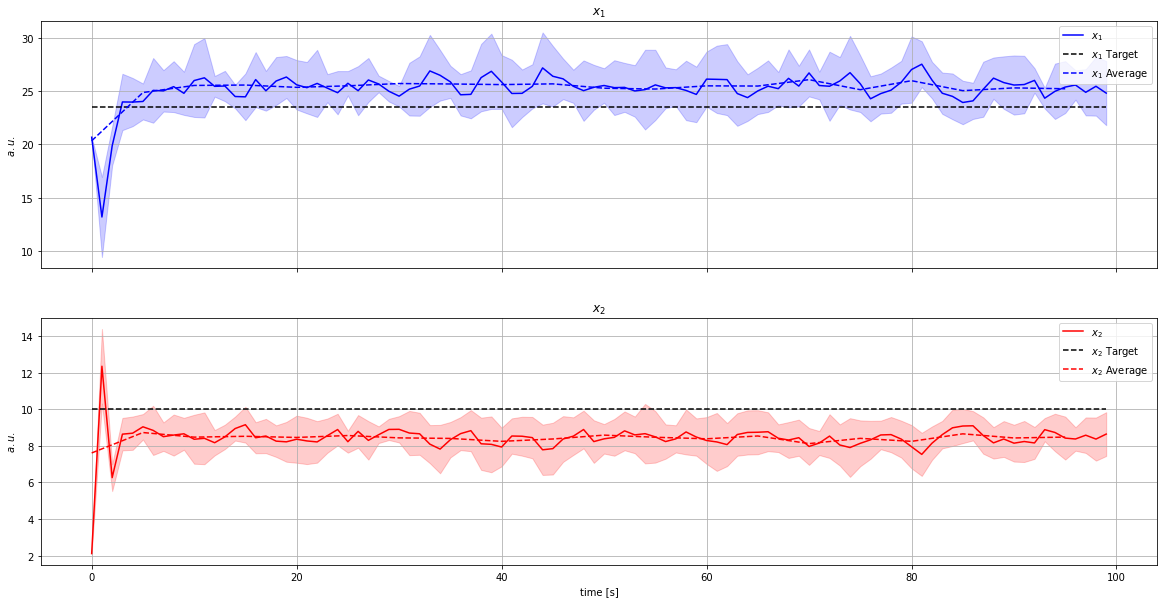

In [10]:
fig_x = 20
fig_y = 10

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

avg_period = 5
avg_samples_range = int(avg_period/t_step)
avg_x = np.arange(0, total_time, avg_period)

x1_avg = [np.mean(mean[x:x + avg_samples_range, 0]) for x in range(0, len(mean[:, 0]), avg_samples_range)]
x2_avg = [np.mean(mean[x:x + avg_samples_range, 1]) for x in range(0, len(mean[:, 1]), avg_samples_range)]


figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))

axes[0].set_ylabel(r'$a.u.$')
axes[0].set_title(r'$x_1$')

line_x1, = axes[0].plot(mpc.data['_time'], mean[:, 0], color='b')
line_ref_x1, = axes[0].plot(mpc.data['_time'], 23.48*np.ones(len(mpc.data['_time'])), color='k', linestyle='--')
line_avg_x1, = axes[0].plot(avg_x, x1_avg, color='b', linestyle='--')
axes[0].legend([r'$x_1$', r'$x_1$ Target', r'$x_1$ Average'], loc='upper right')
axes[0].fill_between([x[0] for x in mpc.data['_time'].tolist()], (mean[:, 0] - std[:, 0]), (mean[:, 0] + std[:, 0]), color='b', alpha=0.2)

axes[1].set_ylabel(r'$a.u.$')
axes[1].set_title(r'$x_2$')
line_TetR, = axes[1].plot(mpc.data['_time'], mean[:, 1], color='r')
line_ref_TetR, = axes[1].plot(mpc.data['_time'], 10.00*np.ones(len(mpc.data['_time'])), color='k', linestyle='--')
line_avg_TetR, = axes[1].plot(avg_x, x2_avg, color='r', linestyle='--')
axes[1].legend([r'$x_2$', r'$x_2$ Target', r'$x_2$ Average'], loc='upper right')
axes[1].set_xlabel('time [s]')
axes[1].fill_between([x[0] for x in mpc.data['_time'].tolist()], (mean[:, 1] - std[:, 1]), (mean[:, 1] + std[:, 1]), color='r', alpha=0.2)

figure.set_facecolor("white")
figure.savefig('./results/fdp_results.png')


In [11]:
ISE, ITAE = compute_performance_metrics(x1_avg, x2_avg, avg_x, total_time, t_step)
print('ISE:', format(ISE, '.2e'))
print('ITAE:', format(ITAE, '.2e'))

ISE: 3.22e+00
ITAE: 8.99e+02
